# <center style="color:red">Community detection in social network.</center>

### <center> <ins >Nguyễn Thị Thương<br><br>Nguyễn Ngọc Trí Vĩ <br><br>Nguyễn Bá Ngọc <br><br>

# <font color='blue'><u> Outline:</u></font> <br>

<font color = 'blue'>
    
> ####  [I. Thư viện:](#1)

> ####  [II. Phương pháp:](#2)

<a id = "1"></a><br>
# <font color='blue'><u> I. Thư viện được sử dụng:</u></font> <br>


In [1]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn import metrics
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import lil_matrix
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

<a id = "2"></a><br>
# <font color='blue'><u> II. Phương pháp</u></font> <br>
> ## <font color='green'><u> Phương pháp 1:</u> Tiếp cận dựa trên cạnh</font> <br>
> > ### <font color='brown'><u> Biểu diễn dữ liệu bằng đồ thị </u></font> <br>

In [3]:
directory = "twitter/" 

# Chọn tệp .featnames
pattern = os.path.join(directory, "*.featnames")

# Lấy danh sách tên file phù hợp với mẫu
filenames = glob.glob(pattern)

nodeIds = []
for filename in filenames:
    starting_index = filename.find("\\")+1
    ending_index = filename.find(".")
    nodeIds.append(int(filename[starting_index:ending_index]))

xuất ra 2 đỉnh của 1 file .edges, tìm thấy dấu cách thì nó sẽ phân ra đỉnh 1 là source, đỉnh 2 là target

In [37]:
edges = []
# Chọn tệp .edges
edge_files = glob.glob(os.path.join(directory, "*.edges"))

for edge_file in edge_files:
    with open(edge_file, "r") as file:
        for line in file:
            source, target = line.strip().split()
            edges.append((int(source), int(target)))

tìm xem trong mỗi file .edges nó có tồn tại trong file .featnames không, nếu có thì 2 đỉnh đó được chọn

In [38]:
selected_edges = []
for edge in edges:
    if (edge[0] in nodeIds) and (edge[1] in nodeIds):
        selected_edges.append(edge)
selected_edges

[(324201646, 40981798),
 (314316607, 430313102),
 (43003845, 314316607),
 (314316607, 187773078),
 (148519842, 195475105),
 (148519842, 86799233),
 (187773078, 314316607),
 (152388029, 158419434),
 (314316607, 43003845),
 (307458983, 18996905),
 (40981798, 18951737),
 (265077741, 40981798),
 (195475105, 43003845),
 (314316607, 307458983),
 (312284236, 40981798),
 (430313102, 18996905),
 (195475105, 187773078),
 (195475105, 148519842),
 (307458983, 158419434),
 (189875309, 148519842),
 (187773078, 40981798),
 (307458983, 166214735),
 (355823615, 43003845),
 (250340951, 18996905),
 (250340951, 430313102),
 (158419434, 40981798),
 (248883350, 229425177),
 (195475105, 206923844),
 (59588845, 43003845),
 (152388029, 355823615),
 (59588845, 70492333),
 (160237722, 314316607),
 (187773078, 307458983),
 (160237722, 18996905),
 (158419434, 430313102),
 (314316607, 229425177),
 (222090651, 57828817),
 (152388029, 40981798),
 (179138862, 18996905),
 (229425177, 40981798),
 (195475105, 248883350),

In [6]:
edges = selected_edges

In [7]:
# Tạo biểu đồ
graph = nx.Graph()

#thêm các cạnh từ danh sách edges vào biểu đồ, nối cạnh với nhau
graph.add_edges_from(edges)

# Hiển thị 1000 node đầu tiên
subset_nodes = list(graph.nodes)[:1000] 
subset_graph = graph.subgraph(subset_nodes)

# Định vị các node, sao cho khoảng cách tối thiểu giữa các nút
pos = nx.spring_layout(subset_graph)

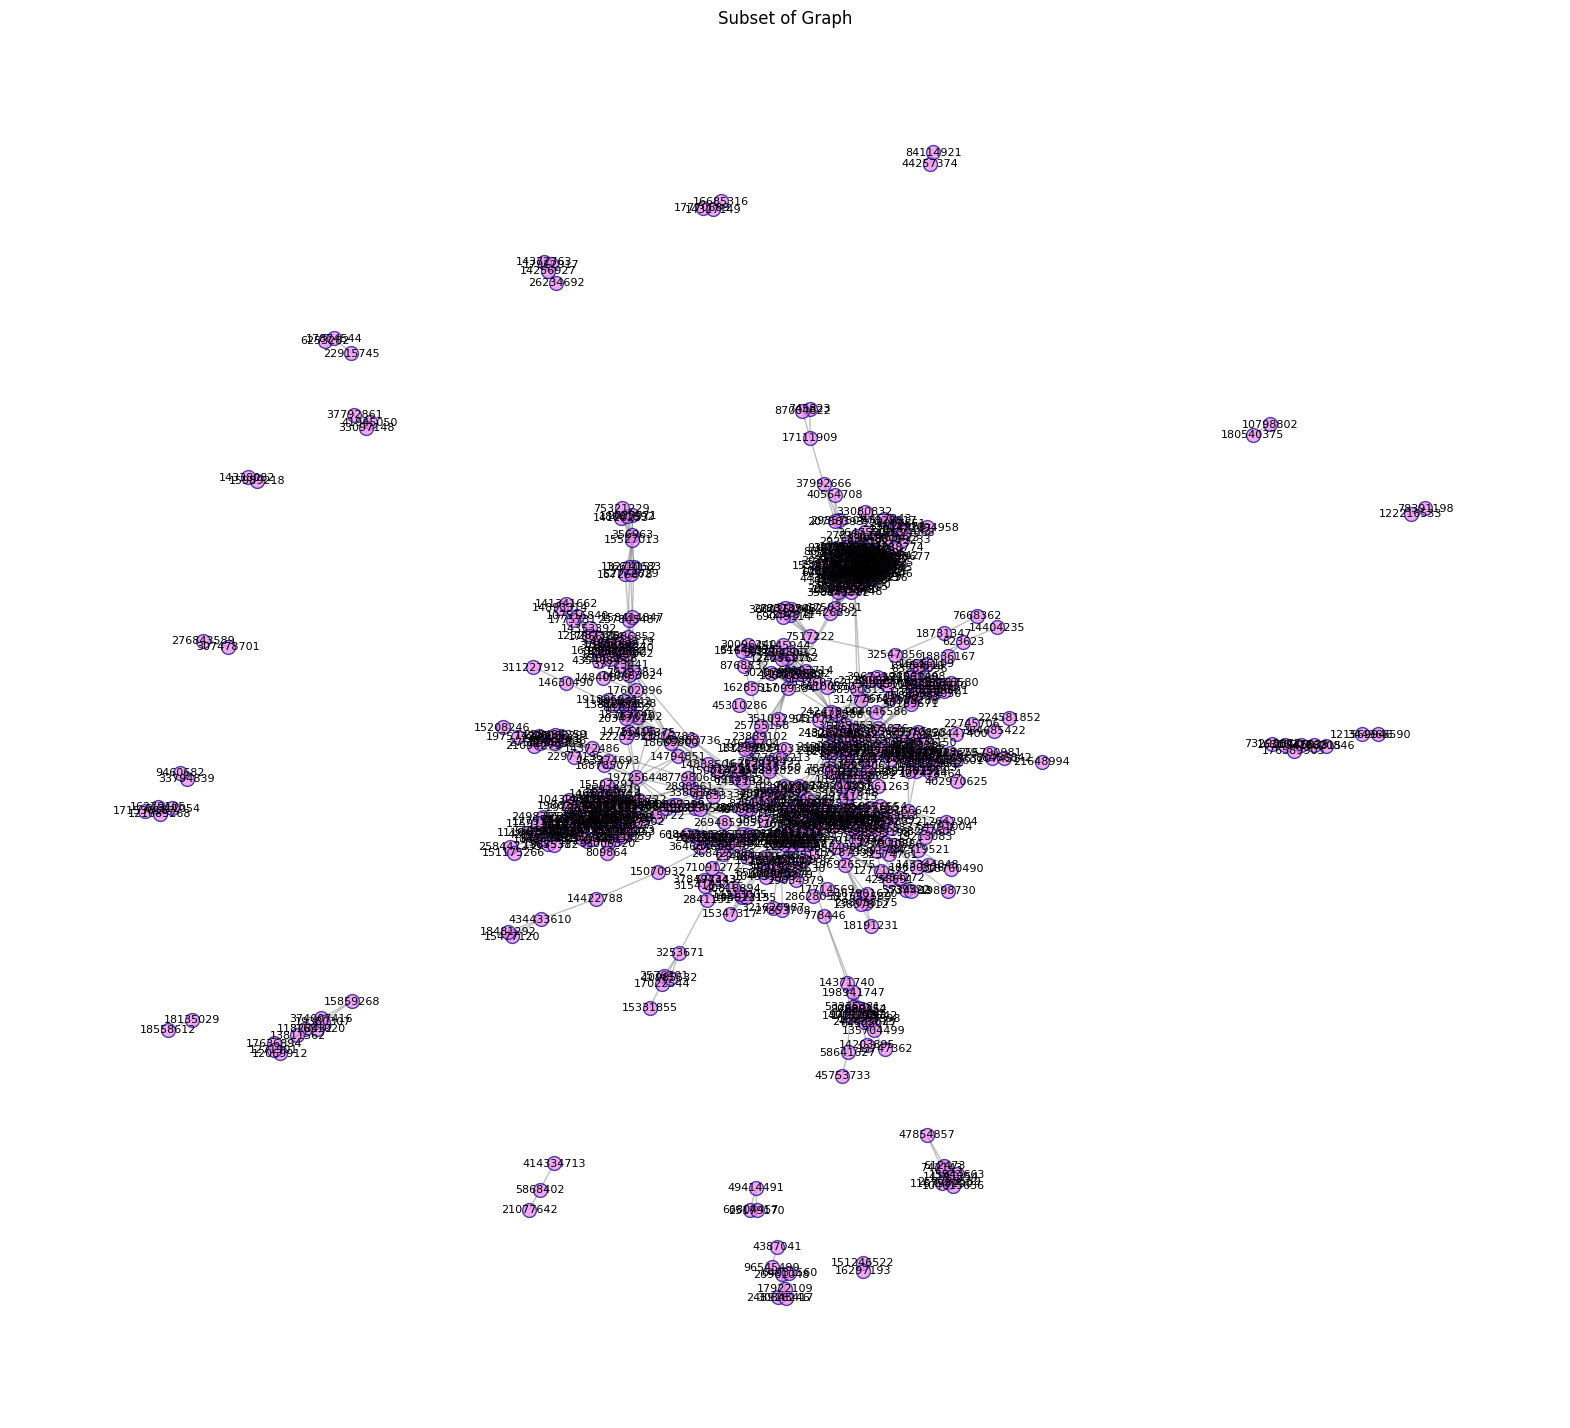

In [8]:
plt.figure(figsize=(20, 18))

# Vẽ node
nx.draw_networkx_nodes(subset_graph, pos, node_color='violet', node_size=100, alpha=0.7, edgecolors='darkblue')

# Vẽ cạnh
nx.draw_networkx_edges(subset_graph, pos, width=1.0, alpha=0.5, edge_color='gray')

# Gắn lable cho mỗi nude
nx.draw_networkx_labels(subset_graph, pos, font_size=8, font_color='black')

plt.axis('off')
plt.title('Subset of Graph')
plt.show()

> > ### <font color='brown'><u>Tiền xử lý dữ liệu: Ma trận kề </u></font> <br>

In [9]:
# Tạo ma trận kề để tiến hành phân tích, để tìm ra các nhóm đỉnh mà có mối quan hệ chặt chẽ với nhau.
nodes = set()

for edge in edges:
    nodes.add(edge[0])
    nodes.add(edge[1])
num_nodes = len(nodes)

# Ánh xạ mỗi đỉnh tới một chỉ số (index). Chỉ số này sẽ Định vị mỗi đỉnh trong ma trận kề.
node_to_index = {node: index for index, node in enumerate(nodes)}

# Tạo ma trận kề
#lil_matrix gắn giá trị cho từng phần tử. ví dụ (hàng, cột) = 1
adjacency_matrix = lil_matrix((num_nodes, num_nodes), dtype=np.int8)
for edge in edges:
    source, target = edge
    source_index = node_to_index[source]
    target_index = node_to_index[target]
    adjacency_matrix[source_index, target_index] = 1

# chuyển đổi lil_matrix sang CSR, CSR chỉ lưu trữ các phần tử khác không trong ma trận
adjacency_matrix = adjacency_matrix.tocsr()
adjacency_matrix.shape

(654, 654)

> > ### <font color='brown'><u> Modeling: Spectral Clustering </u></font> <br>

In [10]:
#Tạo SpectralClustering
model = SpectralClustering(n_clusters=3, affinity='precomputed') #affinity='precomputed' giả định  ma trận đã được tính toán trước đó, đã tính ma trận kề của đồ thị.

# phân cụm các đỉnh của đồ thị
clusters = model.fit_predict(adjacency_matrix)

# tóm lại để phát hiện cộng đồng trong mạng xã hội 

C:\Users\Thuong Nguyen\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
C:\Users\Thuong Nguyen\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


> > ### <font color='brown'><u> Đánh giá số liệu: Spectral Clustering </u></font> <br>

In [11]:
silhouette = silhouette_score(adjacency_matrix, clusters)

print("Cluster Labels:", clusters)
print("Silhouette Score:", silhouette)

Cluster Labels: [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

Silhouette Score là một chỉ số đánh giá chất lượng của phân cụm
Giá trị tốt nhất là gần về 1 và giá trị tệ đi khi gần -1. Các giá trị gần 0 biểu thị các cụm chồng chéo. Các giá trị âm thường chỉ ra rằng một mẫu đã được gán vào cụm sai, vì một cụm khác giống nhau hơn. Tức là phân loại cụm của cộng đồng được gắn của thuật toán SpectralClustering đã bị gắn sai

> ## <font color='green'><u> Phương pháp 2:</u> Tiếp cận dựa trên Feature</font> <br>
> > ### <font color='brown'><u> Biểu diễn dữ liệu dưới dạng bảng </u></font> <br>

In [12]:
#tạo một từ điển (hm) lưu trữ các feature và các node có feature đó.

hm = {}
for nodeId in nodeIds:
    file_path_featnames = "twitter/"+str(nodeId)+".featnames"
    file_path_egofeat = "twitter/"+str(nodeId)+".egofeat"  

    with open(file_path_egofeat, "r") as file:
        egofeat = file.read().split()
        
    with open(file_path_featnames, "r", encoding='utf-8') as file:
        featnames_raw = file.readlines()

    #trong mỗi tệp của .egofeat, mỗi giá trị 1 tương ứng với feature đó có node có feauture tương ứng. Tức là giả sử tệp *.egofeat có giá trị là [0, 1, 0, 0, 1] tương ứng feature_A, feature_B, feature_C, feature_D, feature_E thì chỉ có feature_B và feature_E là các đặc tính này được lưu trữ trong tệp *.featnamesl với * là tên tệp giống nhau
    index_ones = [ index for index,char in enumerate(egofeat) if char =='1' ]
    
    #Trích xuất tên của các tính năng từ tệp .featnames
    featurenames1=[]    
    for line in featnames_raw:
        starting_index = line.find(" ")
        ending_index = line.find('\n')
        featurenames1.append(line[starting_index+1:ending_index])    
    #Lưu trữ các nodeId vào từ điển hm dựa trên các tính năng có giá trị '1'
    for index in index_ones:
        featurename = featurenames1[index]
        if featurename not in hm:
            hm[featurename]=[]
            hm[featurename].append(nodeId)
        else:
            hm[featurename].append(nodeId)
hm

{'#Notícia:': [100318079, 155661154, 186909156, 187773078, 355823615],
 '#xatiada': [100318079],
 '@19ester': [100318079],
 '@AvrilBrasil': [100318079, 165598423, 33612973],
 '@FCCrushParamore': [100318079, 248224845],
 '@ForLoveParamore:': [100318079, 188102842],
 '@HayleyBRCom': [100318079,
  152388029,
  179138862,
  187773078,
  19933035,
  229425177,
  248883350,
  265077741,
  31246395,
  70492333],
 '@HayleyBrasil': [100318079,
  179138862,
  187773078,
  250340951,
  292560337,
  307458983,
  46160500],
 '@LiveForHayley:': [100318079,
  158419434,
  186909156,
  200214366,
  40981798,
  86560711],
 '@O_ProfetaDiario:': [100318079],
 '@PAOCOMPARAMORE': [100318079, 216843160, 355823615, 65185224],
 '@Panetoni': [100318079, 45333725],
 '@ParamoreBEWARE': [100318079, 197903282, 528575851],
 '@Paramore_FC_BR': [100318079, 202195505, 216843160, 227650565, 229741646],
 '@SPINmagazine:': [100318079, 160237722, 187773078],
 '@TheParamoreBand': [100318079,
  151495845,
  160237722,
  166

In [13]:
#Điền các giá trị đặc tính cho từng node dựa trên thông tin trong từ điển hm
#Các node có đặc tính cụ thể sẽ được gán giá trị 1, ngược lại giá trị mặc định là 0.
df = pd.DataFrame(columns = ["nodeId"]+list(hm.keys()))
df["nodeId"]=nodeIds
#Điền các ô trống trong DataFrame với giá trị 0
df = df.fillna(0)
for item,value in hm.items():
    featurename = item
    nodes = value
    for node in nodes:
        #Đặt giá trị 1 cho ô tương ứng với node đó và đặc tính đó
        df.loc[ df["nodeId"]==node ,featurename] = 1
df

,nodeId,#Notícia:,#xatiada,@19ester,@AvrilBrasil,@FCCrushParamore,@ForLoveParamore:,@HayleyBRCom,@HayleyBrasil,@LiveForHayley:,...,@ptscientists,@redbullracing,@shephallmassive,#RioCon,@DEADmatheus,@DEADmatheus:,@anthony2_,@ieroina:,@mishacollins:,@rocknrollbby_
0,100318079,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,10146102,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,101859065,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,101903164,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,102765423,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,98345808,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
969,9855382,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
970,98633794,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
971,98801140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Đánh giá tầm quan trọng hoặc ảnh hưởng của các nút trong mạng xã hội

# Xác định các nút có nhiều kết nối nhất trong đồ thị
degree_centrality = nx.degree_centrality(graph)
print("Degree Centrality:", degree_centrality)

# Xác định các nút có khoảng cách trung bình ngắn nhất đến tất cả các nút khác
closeness_centrality = nx.closeness_centrality(graph)
print("Closeness Centrality:", closeness_centrality)

# Xác định các nút nằm trên nhiều đường đi ngắn nhất giữa các cặp nút khác
betweenness_centrality = nx.betweenness_centrality(graph)
print("Betweenness Centrality:", betweenness_centrality)

Degree Centrality: {324201646: 0.004594180704441042, 40981798: 0.1332312404287902, 314316607: 0.033690658499234305, 430313102: 0.01990811638591118, 43003845: 0.1225114854517611, 187773078: 0.06584992343032159, 148519842: 0.013782542113323125, 195475105: 0.056661562021439515, 86799233: 0.0030627871362940277, 152388029: 0.016845329249617153, 158419434: 0.0444104134762634, 307458983: 0.04134762633996937, 18996905: 0.07503828483920368, 18951737: 0.03522205206738132, 265077741: 0.01225114854517611, 312284236: 0.007656967840735069, 189875309: 0.026033690658499236, 166214735: 0.021439509954058193, 355823615: 0.013782542113323125, 250340951: 0.015313935681470138, 248883350: 0.02756508422664625, 229425177: 0.018376722817764167, 206923844: 0.033690658499234305, 59588845: 0.006125574272588055, 70492333: 0.030627871362940276, 160237722: 0.022970903522205207, 222090651: 0.006125574272588055, 57828817: 0.0030627871362940277, 179138862: 0.016845329249617153, 102765423: 0.0030627871362940277, 11522138

In [15]:
# Tạo ba cột mới trong DataFrame df với các giá trị ban đầu là NaN 
df["Degree Centrality"]=np.nan
df["Closeness Centrality"]=np.nan
df["Betweenness Centrality"]=np.nan

C:\Users\Thuong Nguyen\AppData\Local\Temp\ipykernel_19684\2905337359.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Degree Centrality"]=np.nan
C:\Users\Thuong Nguyen\AppData\Local\Temp\ipykernel_19684\2905337359.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Closeness Centrality"]=np.nan
C:\Users\Thuong Nguyen\AppData\Local\Temp\ipykernel_19684\2905337359.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

In [16]:
# Cập nhật từng phần tử cho các cột
for item,value in degree_centrality.items():
    df.loc[df["nodeId"]==item, "Degree Centrality"]=value
for item,value in closeness_centrality.items():
    df.loc[df["nodeId"]==item, "Closeness Centrality"]=value
for item,value in betweenness_centrality.items():
    df.loc[df["nodeId"]==item, "Betweenness Centrality"]=value

In [17]:
df.dropna(inplace=True)
df.to_csv("dataset.csv",index=False)

> > ### <font color='brown'><u> Phân cụm và đánh giá:  </u></font> <br>

In [18]:
#**kwargs để cho phép hàm nhận bất kỳ đối số từ khóa nào mong muốn.
def cluster_and_evaluate(model_type, num_clusters, data, **kwargs):
    if model_type == "k-means":
        model = KMeans(n_clusters=num_clusters, **kwargs)
    elif model_type == "hierarchical":
        model = AgglomerativeClustering(n_clusters=num_clusters, **kwargs)
    elif model_type == "spectral":
        model = SpectralClustering(n_clusters=num_clusters, **kwargs)
    else:
        raise ValueError("Invalid model type. Valid options: 'k-means', 'hierarchical', 'spectral'.")

    # Điều chỉnh mô hình và thu được nhãn dự đoán
    labels = model.fit_predict(data)
    
    # Đánh giá
    evaluation_metrics = {
        "Silhouette Score": metrics.silhouette_score(data, labels),
    }
    
    return labels, evaluation_metrics


> > ### <font color='brown'><u> K-MEANS  </u></font> <br>

In [19]:
data=df
# Phân cụm dữ liệu bằng k-mean với 3 cụm
labels, metricss = cluster_and_evaluate("k-means", 3, data, random_state=42)

# In labels và đánh giá số liệu
print("Cluster Labels:", labels)
print("Evaluation Metrics:")
for metric, value in metricss.items():
    print(metric + ":", value)

Cluster Labels: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0
 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1
 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1
 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0
 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 2 2 2
 2 2 2 1 2 2 1 1 2 1 2 1 2 2 1 1 2 1 2 2 2 2 1 2 2 2 2 2 1 2 1 1 2 1 2 1 2
 2 1 2 2 1 1 2 2 2 2 1 2 1 1 1 1 2 2 2 2 1 2 2 1 2 2 2 1 1 2 1 1 2 2 1 2 2
 2 1 2 1 1 1 2 1 1 2 1 2 1 2 1 2 1 1 2 2 1 2 1 2 1 2 1 2 2 1 1 2 1 2 2 2 1
 1 1 2 1 

> > ### <font color='brown'><u> Hierarchical Clustering  </u></font> <br>

In [20]:
data=df
# Phân cụm dữ liệu bằng hierarchical clustering với 3 cụm
labels1, metricss1 = cluster_and_evaluate("hierarchical", 3, data)

# In labels và đánh giá số liệu
print("Cluster Labels:", labels1)
print("Evaluation Metrics:")
for metric, value in metricss1.items():
    print(metric + ":", value)

Cluster Labels: [0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 2 2 0 0 0 2 2 0 0 0 0 0 2 0 2 2 0
 0 2 0 0 0 0 0 0 2 2 0 0 2 2 0 0 0 2 2 2 2 0 0 0 0 0 2 0 2 2 2 2 2 2 2 2 2
 0 2 2 2 2 2 2 2 0 2 2 0 2 2 2 0 2 2 2 2 0 2 2 0 2 2 0 2 2 2 2 2 2 2 2 2 2
 2 0 2 2 2 2 2 2 2 0 0 2 0 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 2 2 0 0 2
 2 0 2 2 2 0 0 2 2 0 2 2 2 2 2 2 2 2 0 0 0 0 2 2 2 2 0 0 2 2 2 0 2 0 2 0 2
 0 2 0 2 2 0 2 0 2 2 0 2 2 2 0 2 2 0 0 2 2 2 2 2 2 2 2 2 0 2 2 0 2 2 2 2 2
 2 2 0 2 2 0 0 2 2 2 2 0 2 2 0 2 2 0 2 2 0 0 0 0 2 2 2 0 2 0 2 2 0 0 2 2 0
 2 2 0 0 2 2 2 2 2 2 0 2 2 2 0 2 0 0 2 0 0 0 0 2 0 2 2 0 0 2 2 2 0 0 0 2 2
 2 2 0 2 0 2 0 0 2 2 2 2 2 2 0 0 2 2 2 2 2 2 0 2 2 0 0 2 1 2 1 1 2 2 1 1 1
 2 2 2 1 2 2 1 2 1 1 1 1 1 1 1 2 2 1 2 1 2 2 1 2 1 1 2 1 1 1 1 1 2 2 1 1 1
 1 1 1 2 1 1 2 2 1 2 1 2 1 1 2 2 1 2 1 1 1 1 2 1 1 1 1 1 2 1 2 2 1 2 1 2 1
 1 2 1 1 2 2 1 1 1 1 2 1 2 2 2 2 1 1 1 1 2 1 1 2 1 1 1 2 2 1 2 2 1 1 2 1 1
 1 2 1 2 2 2 1 2 2 1 2 1 2 1 2 1 2 2 1 1 2 1 2 1 2 1 2 1 1 2 2 1 2 1 1 1 2
 2 2 1 2 

> > ### <font color='brown'><u> Spectral Clustering  </u></font> <br>

In [21]:
data=df
# Phân cụm dữ liệu bằng spectral clustering với 3 cụm
labels2, metricss2 = cluster_and_evaluate("spectral", 3, data, random_state=42)

# In labels và đánh giá số liệu
print("Cluster Labels:", labels2)
print("Evaluation Metrics:")
for metric, value in metricss2.items():
    print(metric + ":", value)

C:\Users\Thuong Nguyen\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Cluster Labels: [0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 2 1 0 1 0 1 0 0 0 0 0 2 1 1 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0
 0 0 2 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 1 0 1
 0 1 0 2 1 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 1 0 0 0 2 0 2 0 0 0 2 0 0 0
 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 1 1 0 0 2 2 0 0 1 1 0 0 0 0 2 1 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 2 0 2 0 0 2 0 0 0 0 0 0 2 0
 2 0 0 0 0 0 0 2 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0
 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 2 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 2 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 1 2 0 0 0 0 0 1 0 1 0 0 0 2 0 0 1 0 0 2 2 0 0 0
 0 0 0 1 0 0 2 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 2 0 2 0 0 0 0 0 0 1 0 2 2 0 0
 0 0 0 0 

> > ### <font color='brown'><u> Labeling  </u></font> <br>

In [22]:
# lấy label của mô hình hoạt động tốt nhất: KMEANS
df["class"] = labels
df0 = df.loc[df["class"]==0]
df1 = df.loc[df["class"]==1]
df2 = df.loc[df["class"]==2]

C:\Users\Thuong Nguyen\AppData\Local\Temp\ipykernel_19684\1092220494.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["class"] = labels


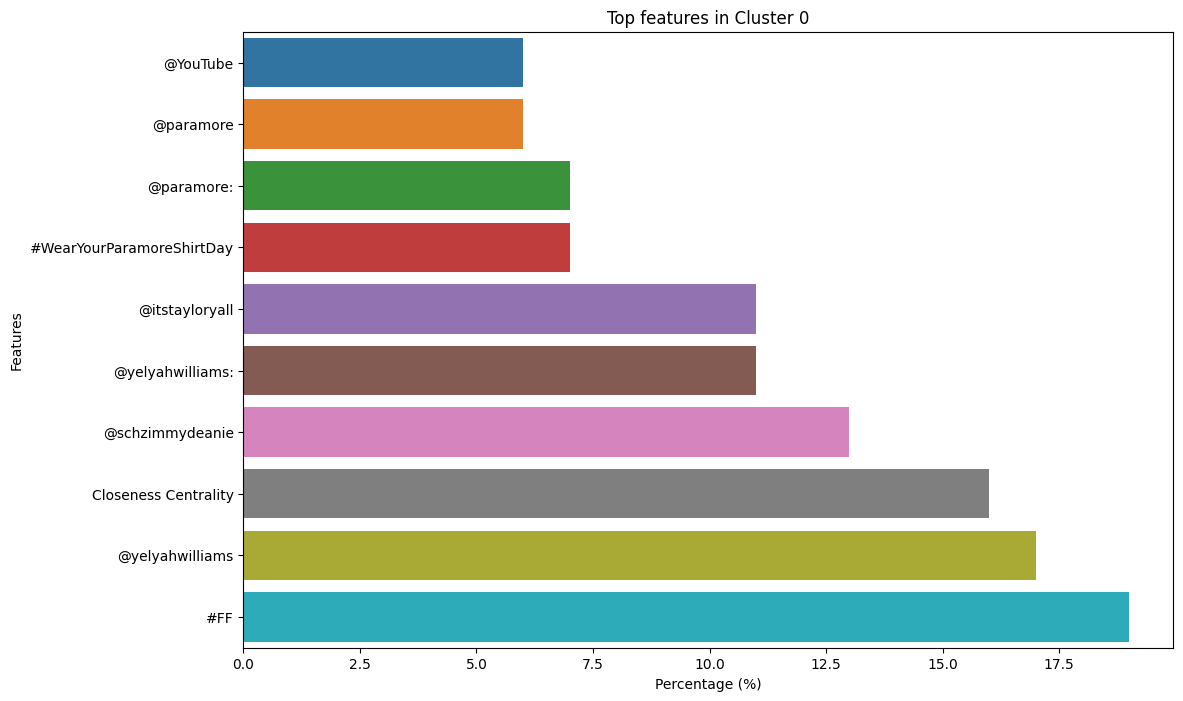

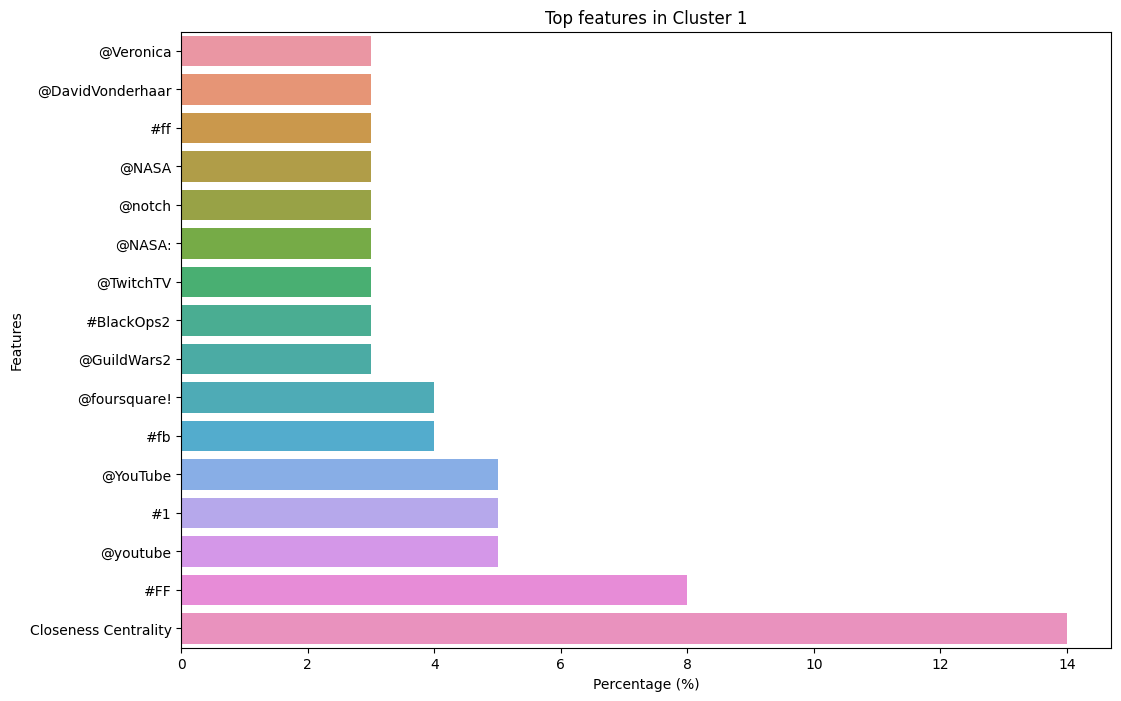

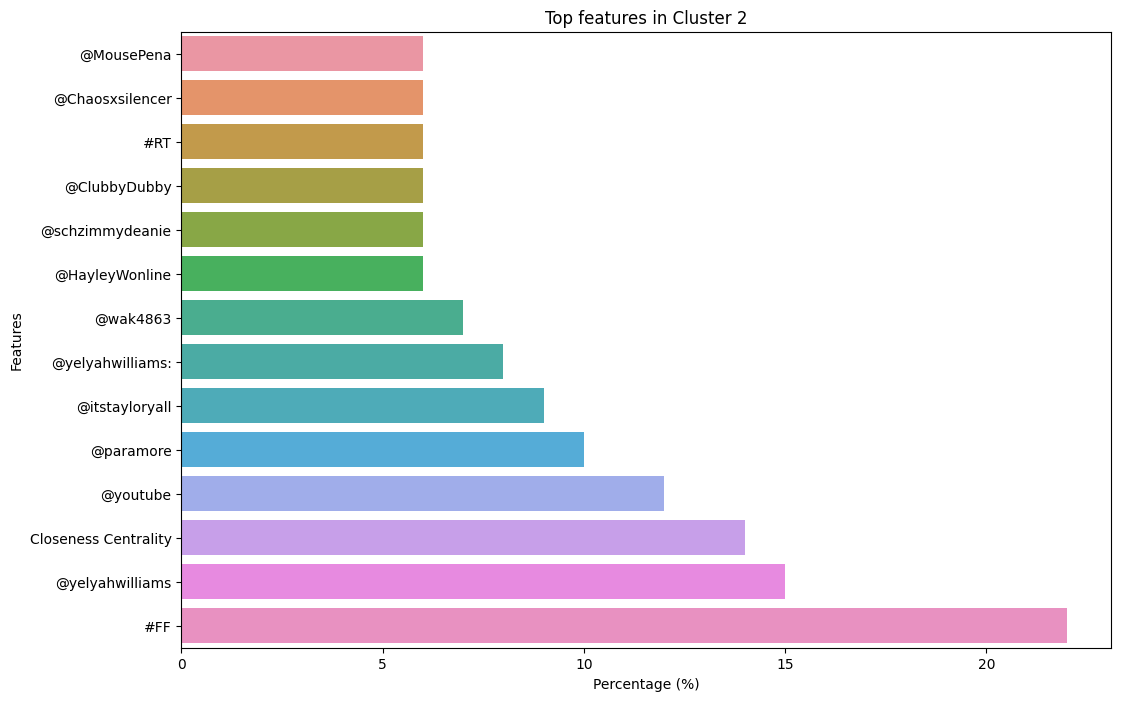

Top features in Cluster 0:
                            0
@YouTube                    6
@paramore                   6
@paramore:                  7
#WearYourParamoreShirtDay   7
@itstayloryall             11
@yelyahwilliams:           11
@schzimmydeanie            13
Closeness Centrality       16
@yelyahwilliams            17
#FF                        19

Top features in Cluster 1:
                       0
@Veronica              3
@DavidVonderhaar       3
#ff                    3
@NASA                  3
@notch                 3
@NASA:                 3
@TwitchTV              3
#BlackOps2             3
@GuildWars2            3
@foursquare!           4
#fb                    4
@YouTube               5
#1                     5
@youtube               5
#FF                    8
Closeness Centrality  14

Top features in Cluster 2:
                       0
@MousePena             6
@Chaosxsilencer        6
#RT                    6
@ClubbyDubby           6
@schzimmydeanie        6
@HayleyWonli

In [54]:
# Hàm vẽ đồ thị phân phối feature trong một cụm
def plot_feature_distribution(df_cluster, cluster_name, threshold_low, threshold_high):
    df_cluster_sum = ((df_cluster.sum().sort_values() / df_cluster.shape[0]) * 100).astype(int).to_frame()
    filtered_df_sum = df_cluster_sum.loc[(threshold_high > df_cluster_sum[0]) & (df_cluster_sum[0] > threshold_low),]
    
    plt.figure(figsize=(12, 8))
    sns.barplot(y=filtered_df_sum.index, x=filtered_df_sum[0], orient='h')
    plt.title(f"Top features in {cluster_name}")
    plt.xlabel("Percentage (%)")
    plt.ylabel("Features")
    plt.show()
    
    return filtered_df_sum

# Lấy các feature của từng biểu đồ
features_cluster_0 = plot_feature_distribution(df0, "Cluster 0", 5, 22)
features_cluster_1 = plot_feature_distribution(df1, "Cluster 1", 2, 20)
features_cluster_2 = plot_feature_distribution(df2, "Cluster 2", 5, 23)

# Các feature của mỗi cụm
print("Top features in Cluster 0:")
print(features_cluster_0)

print("\nTop features in Cluster 1:")
print(features_cluster_1)

print("\nTop features in Cluster 2:")
print(features_cluster_2)
